# TRANSFER LEARNING FROM IMAGENET TO CERVIX

In this notebook I show how to train the top layer of a network during the transfer learning process. I have created some dummy modules that will need to be substituted as soon as the real modules of the projects are implemented (balanced batch generator, train test split etc.)

It also shows how to train not only the top part of the model (aka the new layers stacked to fit our problem) but also some other layers of the pretrained model. This is something that we really want to do since the features extracted by the pretrained net at the middle last part potentially need to be finetuned.

https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

I would say not to touch the first 15% of layers of the pretrained models, since the features that they extract are low level and hence are still useful in our domain. This said, this notebook also shows how to use the pretrained weights just as initialization and then train the whole net.

I think a good way to go is first train only the **top (last) layers**, then fine tune **~half the layers** and finally fine tune **all of them**. Of course we would keep track of the metrics and so we will be able to which is helpful and which is not.

I recommend not to train using the notebook but a script so the process is independent on the browser. Also sometimes the verbosity of the training creates problems.

Also tensorboard is useful for monitoring the training http://stackoverflow.com/questions/37987839/how-can-i-run-tensorboard-on-a-remote-server



In [1]:
import sys
import os
sys.path.insert(0,os.path.join('..','scripts'))
from network import Network, Temp
from matplotlib import pyplot as plt
import generator
%matplotlib inline

Using TensorFlow backend.


## GENERATORS

The real generators have not been built yet, so in order to build the training module and test it I coded some **dummy** generators. In this case, the generators read directly from the raw images and apply some basic augmentation on the fly (not tested enough at all). I manually-randomly splitted a train and val set as well(put them in separate folders).
We have to instantiate them now in order to assign them to the network later. We also sample a few images to get an idea of what will be fed to net.

https://keras.io/preprocessing/image/

In [ ]:
train_generator, val_generator = Temp().get_dummy_generators()
for x,y in train_generator:
    break
print x.min(), x.max(),x.mean()
for i in range(10):
    plt.figure()
    plt.imshow(x[i])
    plt.title(str(list(y[i])))
    plt.show()

### Split generators

NameError: name 'x' is not defined

In [2]:
g = generator.BatchGenerator(source = 'pre')
train_filepaths, train_filetargets, val_filepaths, val_filetargets = g.get_splitted_paths_from_csv(use_additional = False)
train_generator = g.generate(data = train_filepaths, labels = train_filetargets, batch_size = 32, shuffle = True)
val_generator = g.generate(data = val_filepaths, labels = val_filetargets, batch_size = 32, shuffle = True)

a = 500
for x,y in train_generator:  
    a -= 1
    print x.shape, y.shape
    '''plt.figure()
    plt.imshow(x[0])
    plt.show()'''
    if a == 0:
        break
a = 3
for x,y in val_generator:  
    a -= 1
    '''plt.figure()
    plt.imshow(x[0])
    plt.show()'''
    if a == 0:
        break

Validation split:
	75 of type 1
	234 of type 2
	135 of type 3
Training split:
	250 of type 1
	781 of type 2
	450 of type 3
46


ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [15]:
y.shape

AttributeError: 'list' object has no attribute 'shape'

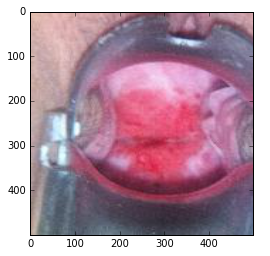

In [10]:
x,y = train_generator.next()
plt.figure()
plt.imshow(x[0])
plt.show()

## TOP LAYERS TRAINING

We load the architecture of the network resnet with its weights. In this case we chose Xcpetion. The method adapts that architecture to our problem (3 classes). Moreover, it freezes all the pretrained layers with the aim of first training only the newly added layers (actual fine tuning will happen in later steps).

Something is going wrong with the summary variable (see the annoying prints in the code cells). I havent been able to fix it nor the people talking about it here https://github.com/fchollet/keras/issues/5746 , however I don't see those prints when training from a script

In [7]:
network = Network(arch = 'xception')
network.freeze_all_pretrained_layers()
network.set_train_val_generators(train_generator, val_generator)
network.compile(finetuning = False)
network.train(epochs = 100, batch_size = 32)

Original Imagenet weights for network xception loaded
Freezing all pretrained layers...
Using optimizer: adam
135 total layers ( 132 pretrained and 3 new stacked on top)
	132 non-trainable layers: from 0 to 131
	3 trainable layers: from 132 to 134
Trainable layer map: 000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000111
INFO:tensorflow:Summary name block1_conv1/kernel:0 is illegal; using block1_conv1/kernel_0 instead.
INFO:tensorflow:Summary name block1_conv1/kernel:0 is illegal; using block1_conv1/kernel_0 instead.
INFO:tensorflow:Summary name block1_conv1_bn/gamma:0 is illegal; using block1_conv1_bn/gamma_0 instead.
INFO:tensorflow:Summary name block1_conv1_bn/gamma:0 is illegal; using block1_conv1_bn/gamma_0 instead.
INFO:tensorflow:Summary name block1_conv1_bn/beta:0 is illegal; using block1_conv1_bn/beta_0 instead.
INFO:tensorflow:Summary name block1_conv1_bn/beta:0 is illegal; using block1_conv1_bn

Exception in thread Thread-6:
Traceback (most recent call last):
  File "/usr/lib/python2.7/threading.py", line 810, in __bootstrap_inner
    self.run()
  File "/usr/lib/python2.7/threading.py", line 763, in run
    self.__target(*self.__args, **self.__kwargs)
  File "/home/vgarciacazorla/virtual_envs/1v/local/lib/python2.7/site-packages/keras/engine/training.py", line 612, in data_generator_task
    generator_output = next(self._generator)
ValueError: generator already executing



ValueError: output of generator should be a tuple `(x, y, sample_weight)` or `(x, y)`. Found: None

## FINE TUNING LAST 60% OF LAYERS

Now we want to see what happens if we train also some of the layers of the pretrained model. We will use the output weights of the last step as initialization for the top new layers, although I don't really know to what extent that is important. Anyway if want to do it, we have to manually move the weights from the output folder to the input folder, then copy its filename and pass it when initialising the network (so they will be loaded).

In [ ]:
network = Network(arch = 'xception',
                  input_weights_name = 'xception.3.e003-tloss0.6225-vloss1.0634.hdf5')
network.freeze_all_pretrained_layers()
network.unfreeze_last_pretrained_layers(percentage = 0.6)
network.set_train_val_generators(train_generator, val_generator)
network.compile(finetuning = True)
network.train(epochs = 100, batch_size = 32)

## FINE TUNING ALL LAYERS

Now we will do the same but will fine tune the whole network, taking the output weights of the last step as initialisation.

In [ ]:
network = Network(arch = 'xception',
                  input_weights_name = 'xception.82.e002-tloss0.6390-vloss0.9963.hdf5')
network.set_train_val_generators(train_generator, val_generator)
network.compile(finetuning = True)
network.train(epochs = 100, batch_size = 32)

## TRAINING A SIMPLE NETWORK

In this example I show how to use a simple CNN. Before doing so, it is required to define a method in `network.py` that returns the desired architecture, and assign a model to that method in the `CUSTOM_ARCHS` dictionary of the `network.py` module. In this case, the method we have created is called `custom_1` and we have assigned it the name `"simple_cnn_1"`:

In [ ]:
network = Network(arch = 'simple_cnn_1')
network.set_train_val_generators(train_generator, val_generator)
network.compile(finetuning = False)
network.train(epochs = 100, batch_size = 32)